# Inspired by Davidson et al. 2017. "Automated Hate Speech Detection and the Problem of Offensive Language"

In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
import joblib
from joblib import dump, load

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
nltk.download('averaged_perceptron_tagger')
nltk.download("stopwords")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Nicholas McCarty\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to C:\Users\Nicholas
[nltk_data]     McCarty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
stopwords= nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

In [5]:
sentiment_analyzer = VS()

In [6]:
stemmer = PorterStemmer()

## Loading the data

In [7]:
df = pd.read_csv("data/labeled_data.csv")

In [8]:
tweets=df.tweet

## Feature generation

In [9]:
def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
       '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-\:]+' #<<<<<<added the semicolon after the + to remove : at end of Rt's
    emoji_regex = '&#[0-9\;\:]+'    #<<<<<<<<<remove emoji's .ex; &#1214324
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    parsed_text = re.sub(emoji_regex,'',parsed_text)
    parsed_text = parsed_text.strip(string.punctuation)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split('\s|(?<!\d)[,.]|[,.](?!\d)', tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

In [10]:
vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()}

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', "it'", 'onc', 'onli', 'ourselv', "she'", "should'v", 'themselv', 'thi', 'veri', 'wa', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [11]:
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    #for i in range(0, len(tokens)):
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [12]:
#Construct POS TF matrix and get vocab dict

pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

pos = vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}

In [13]:
def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [14]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [15]:
feats = get_feature_array(tweets)

In [16]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [17]:
M.shape

(24783, 10313)

In [18]:
# #Finally get a list of variable names
# variables = ['']*len(vocab)
# for k,v in vocab.items():
#     variables[v] = k

# pos_variables = ['']*len(pos_vocab)
# for k,v in pos_vocab.items():
#     pos_variables[v] = k

# feature_names = variables+pos_variables+other_features_names

# Running the model

The best model was selected using a GridSearch with 5-fold CV.

In [19]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [22]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

In [23]:
pipe = LogisticRegression(class_weight = 'balanced',
                          max_iter = 1000,
                          multi_class = 'auto',
                          n_jobs = -1)

In [24]:
param_grid = [
    
#   {'C': [.1, 1, 10, 100],
#    'penalty': ['l1'],
#    'solver': ['saga']},
    
#   {'C': [.1, 1, 10, 100],
#    'penalty': ['elasticnet'],
#    'solver': ['saga'],
#    'l1_ratio': [.3, .5, .7]},
    
  {'C': [.1, 1, 10, 100],
   'penalty': ['l1', 'l2'],
   'solver': ['liblinear']},
    
]

In [25]:
grid_search = GridSearchCV(pipe,
                           param_grid,
                           cv=StratifiedKFold(n_splits=3, 
                                              random_state=42).split(X_train, y_train), 
                           verbose=2)

In [26]:
model = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] C=0.1, penalty=l1, solver=liblinear .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV] .............. C=0.1, penalty=l1, solver=liblinear, total=  29.3s
[CV] C=0.1, penalty=l1, solver=liblinear .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.4s remaining:    0.0s
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .............. C=0.1, penalty=l1, solver=liblinear, total= 5.0min
[CV] C=0.1, penalty=l1, solver=liblinear .............................


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .............. C=0.1, penalty=l1, solver=liblinear, total= 1.7min
[CV] C=0.1, penalty=l2, solver=liblinear .............................


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV] .............. C=0.1, penalty=l2, solver=liblinear, total=   8.1s
[CV] C=0.1, penalty=l2, solver=liblinear .............................


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV] .............. C=0.1, penalty=l2, solver=liblinear, total=   6.6s
[CV] C=0.1, penalty=l2, solver=liblinear .............................


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV] .............. C=0.1, penalty=l2, solver=liblinear, total=   4.9s
[CV] C=1, penalty=l1, solver=liblinear ...............................


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV] ................ C=1, penalty=l1, solver=liblinear, total=  25.6s
[CV] C=1, penalty=l1, solver=liblinear ...............................


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=1, penalty=l1, solver=liblinear, total= 2.6min
[CV] C=1, penalty=l1, solver=liblinear ...............................


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................ C=1, penalty=l1, solver=liblinear, total=26.8min
[CV] C=1, penalty=l2, solver=liblinear ...............................


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV] ................ C=1, penalty=l2, solver=liblinear, total=  16.1s
[CV] C=1, penalty=l2, solver=liblinear ...............................


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV] ................ C=1, penalty=l2, solver=liblinear, total=  14.1s
[CV] C=1, penalty=l2, solver=liblinear ...............................


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV] ................ C=1, penalty=l2, solver=liblinear, total=   7.6s
[CV] C=10, penalty=l1, solver=liblinear ..............................


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV] ............... C=10, penalty=l1, solver=liblinear, total=  20.4s
[CV] C=10, penalty=l1, solver=liblinear ..............................


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV] ............... C=10, penalty=l1, solver=liblinear, total=  12.3s
[CV] C=10, penalty=l1, solver=liblinear ..............................


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............... C=10, penalty=l1, solver=liblinear, total=26.0min
[CV] C=10, penalty=l2, solver=liblinear ..............................


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV] ............... C=10, penalty=l2, solver=liblinear, total=  22.2s
[CV] C=10, penalty=l2, solver=liblinear ..............................


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV] ............... C=10, penalty=l2, solver=liblinear, total=  19.1s
[CV] C=10, penalty=l2, solver=liblinear ..............................


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV] ............... C=10, penalty=l2, solver=liblinear, total=   8.4s
[CV] C=100, penalty=l1, solver=liblinear .............................


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV] .............. C=100, penalty=l1, solver=liblinear, total=   6.3s
[CV] C=100, penalty=l1, solver=liblinear .............................


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV] .............. C=100, penalty=l1, solver=liblinear, total=  15.9s
[CV] C=100, penalty=l1, solver=liblinear .............................


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .............. C=100, penalty=l1, solver=liblinear, total=44.5min
[CV] C=100, penalty=l2, solver=liblinear .............................


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV] .............. C=100, penalty=l2, solver=liblinear, total=  29.7s
[CV] C=100, penalty=l2, solver=liblinear .............................


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV] .............. C=100, penalty=l2, solver=liblinear, total=  20.1s
[CV] C=100, penalty=l2, solver=liblinear .............................


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[CV] .............. C=100, penalty=l2, solver=liblinear, total=  13.1s


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 111.3min finished
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [27]:
y_preds = model.predict(X_test)

## Evaluating the results

In [28]:
report = classification_report( y_test, y_preds )

***Note: Results in paper are from best model retrained on the entire dataset (see the other notebook). Here the results are reported after using cross-validation and only for the held-out set.***

In [29]:
print(report)

              precision    recall  f1-score   support

           0       0.38      0.44      0.41       141
           1       0.95      0.90      0.93      1924
           2       0.78      0.93      0.85       414

    accuracy                           0.88      2479
   macro avg       0.70      0.76      0.73      2479
weighted avg       0.89      0.88      0.88      2479



In [39]:
grid_search.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=-1, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

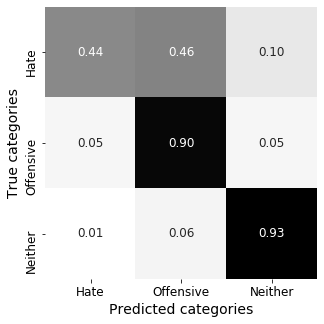

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
# plt.savefig('confusion.pdf')

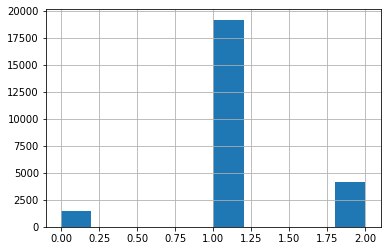

In [32]:
#True distribution
y.hist()

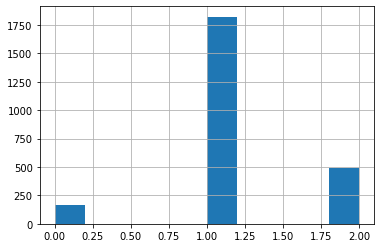

In [33]:
pd.Series(y_preds).hist()

In [34]:
confusion_df

,Hate,Offensive,Neither
Hate,0.439716,0.460993,0.099291
Offensive,0.049896,0.901767,0.048337
Neither,0.014493,0.055556,0.929952


In [38]:
from joblib import dump, load
dump(grid_search.best_estimator_, 'Logistic_Regression_Hypertuned.joblib') 

['Logistic_Regression_Hypertuned.joblib']

In [36]:
from sklearn.metrics import roc_auc_score, auc, roc_curve

probabilities = model.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, probabilities, 0)
roc_auc = auc(fpr, tpr)

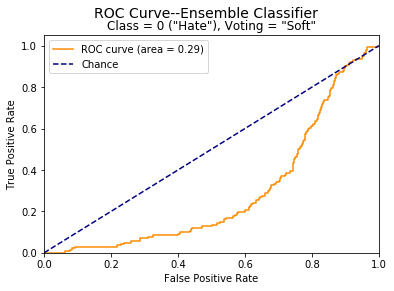

In [37]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', label = 'Chance', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Class = 0 ("Hate")')
plt.suptitle('ROC Curve--Logistic Regression', fontsize=14)
plt.legend(loc="best")
# plt.savefig('ROC Curve--Logistic Regression Classifier.jpeg', dpi = 1200, format = 'jpeg', optimize = True)
plt.show()

In [40]:
test = load('Logistic_Regression_Hypertuned.joblib') 

In [41]:
y_preds = test.predict(X_test)

In [42]:
report = classification_report( y_test, y_preds )

In [43]:
print(report)

              precision    recall  f1-score   support

           0       0.38      0.44      0.41       141
           1       0.95      0.90      0.93      1924
           2       0.78      0.93      0.85       414

    accuracy                           0.88      2479
   macro avg       0.70      0.76      0.73      2479
weighted avg       0.89      0.88      0.88      2479

